In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import math
import argparse
import os
import pandas as pd
import time
import datetime
import logging
import glob
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
label_map = {1:'BottleCap_FaceUp', 2:'BottleCap_FaceDown', 3:'BottleCap_Deformed'}

TEST = True

def show_frame(image, caption='Frame to see'):
    cv.imshow(caption, image)
    cv.waitKey(0)

def save_img(image, filename):
    cv.imwrite(filename, image)


def capture_frames(video_data):
    captured_frames = list()
    img_dict = dict()
    img_list = list()
    img_idx = list()
    frame_diff_list = list()

    cap = cv.VideoCapture(video_data)
    n_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv.CAP_PROP_FPS)


    count = 0
    while cap.isOpened():
        frameId = cap.get(1)  # current frame number
        frame_time = time.time()
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(fps / 2.0) == 0):
            b, g, r = cv.split(frame)
            img = cv.merge((b, g, r))
            gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img_dict[count] = (gray_image)
        count = count+1
    cap.release()
    if TEST:
        print("Frame: {}\nFrames per second: {}".format(n_frames, fps))

    k = img_dict.items()
    for n,i in enumerate(k):
        img_list.append(i[1])
        img_idx.append(i[0])
    print(len(img_list))
    # calculating the frame difference between consecutive frames
    for i in range(1, len(img_list)):
        frame_diff = cv.absdiff(img_list[i], img_list[i - 1])
        frame_diff = cv.GaussianBlur(frame_diff, (3, 3), 0)
        frame_diff = cv.threshold(frame_diff, 25, 255, cv.THRESH_BINARY)[1]
        frame_diff = cv.Canny(frame_diff,200,150)
        frame_diff_list.append(cv.countNonZero(frame_diff))
    
    max_idx = np.argmax(frame_diff_list)
    min_idx = np.argmin(frame_diff_list)
    if img_idx[min_idx + 1] < img_idx[max_idx + 1]:
        pass
    else:
        min_idx = max_idx
#     min_idx = 1  
    print(frame_diff_list)
    print(max_idx, np.argmin(frame_diff_list), min_idx)
    if len(frame_diff_list) > 6 and min_idx > int(len(frame_diff_list) * 0.8):
        min_idx = np.argmin(frame_diff_list[:-2])
    
    # storing the frame with the least consecutive frame difference for further processing
    captured_frames.append(img_list[min_idx + 1])

    return captured_frames[0], img_idx[min_idx + 1]

def run_inference(frozen_graph_path, stable_frame):
    # Read the graph.
    with tf.io.gfile.GFile(frozen_graph_path, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.compat.v1.Session() as sess:
        # Restore session
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name='')

        # Read and preprocess an image.
        img = stable_frame
        rows = img.shape[0]
        cols = img.shape[1]
        inp = cv.resize(img, (300, 300))
        inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

        # Run the model
        out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                        sess.graph.get_tensor_by_name('detection_scores:0'),
                        sess.graph.get_tensor_by_name('detection_boxes:0'),
                        sess.graph.get_tensor_by_name('detection_classes:0')],
                       feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})

        # Visualize detected bounding boxes.
        num_detections = int(out[0][0])
        class_label = list() # list of labelIDs
        bbox_list = list() # list of tuples - x,y, right, bottom

        for i in range(num_detections):
            classId = int(out[3][0][i])
            class_label.append(classId)
            score = float(out[1][0][i])
            bbox = [float(v) for v in out[2][0][i]]
            if score > 0.3:
                x = bbox[1] * cols
                y = bbox[0] * rows
                right = bbox[3] * cols
                bottom = bbox[2] * rows
                tuple_data = (x, y, right, bottom)
                bbox_list.append(tuple_data)
                if TEST:
                    cv.rectangle(img, (int(x), int(y)), (int(right), int(bottom)), (125, 255, 51), thickness=2)

    if TEST:
        name = frozen_model_path + "/Videos/ouput/1_box.jpg"
        cv.imwrite(name, img)
#         show_frame(img, 'TensorFlow MobileNet-SSD')

    return class_label, bbox_list

def get_point(bounding_box):

    x,y = bounding_box[0], bounding_box[1]
    right, bottom = bounding_box[2], bounding_box[3]
    center_top = (x + right)/2.
    center_right = (y + bottom)/2.

    return center_top, center_right

def get_label_marker_position(bounding_box):

    x, y = bounding_box[0], bounding_box[1]
    x_marker = x
    y_marker = y-5

    return x_marker, y_marker

def get_output_format(class_label, bounding_box, selected_frame):
    label_name = list()
    for i in class_label:
        label_name.append(label_map[int(i)])

    x_list = list()
    y_list = list()
    for i in bounding_box:
        center_x, center_y = get_point(i)
        x_list.append(center_x)
        y_list.append(center_y)

    lines_in_output = list()

    for i in zip(x_list, y_list, label_name):
        lines_in_output.append(str(selected_frame)+','+str(int(i[0]))+','+str(int(i[1]))+','+i[2])

    return(lines_in_output)

def enhance_CLAHE(img):
    # -----Converting image to LAB Color model-----------------------------------
    lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

    # -----Splitting the LAB image to different channels-------------------------
    l, a, b = cv.split(lab)

    # -----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(5, 5))
    cl = clahe.apply(l)
    # show_frame(cl, 'CLAHE output')

    # -----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv.merge((cl, a, b))

    # -----Converting image from LAB Color model to RGB model--------------------
    final = cv.cvtColor(limg, cv.COLOR_LAB2BGR)

    return final



In [69]:
input_video_path = "/home/ganesh/Documents/3rd_semester/CV/project/models/research/object_detection/Videos/CV20_video_190.mp4"
frozen_model_path = "/home/ganesh/Documents/3rd_semester/CV/project/models/research/object_detection"
output_folder_path = "/home/ganesh/Documents/3rd_semester/CV/project/models/research/object_detection/result"
input_image_path = "/home/ganesh/Documents/3rd_semester/CV/project/models/research/object_detection/images/test/CV20*.png"


In [70]:
image_data = True
image_number = 1
result = []

if __name__ == '__main__':
    
    if image_data:
        for filename in glob.glob(input_image_path):
            print("Loop [%s]" % str(image_number) )
            stable_frame=cv.imread(filename)
            #     logging.info("Running inference [%s]" % str(datetime.datetime.now()))
            print("Running inference [%s]" % str(datetime.datetime.now()))
            class_label, bounding_box = run_inference(frozen_graph_path, stable_frame)
            print("Inference run completed [%s]" % str(datetime.datetime.now()))

        #     logging.info("Inference run completed [%s]" % str(datetime.datetime.now()))

            lines_in_output = get_output_format(class_label, bounding_box, selected_frame)
        #     print(lines_in_output)

            if TEST:
                # To draw bounding box and label the predictions.

                x_list = list()
                y_list = list()
                label_color_list = list()
                label_name_list = list()
                label_color = {1:(255,0,0), 2:(0,255,0), 3:(0,0,255)}
                for i in bounding_box:
                    center_x, center_y = get_point(i)
                    x_list.append(center_x)
                    y_list.append(center_y)

                x_marker = list()
                y_marker = list()
                for i in bounding_box:
                    x_m, y_m = get_label_marker_position(i)
                    x_marker.append(x_m)
                    y_marker.append(y_m)

                for i in class_label:
                    label_color_list.append(label_color[int(i)])

                for i in class_label:
                    label_name_list.append(label_map[int(i)])

                for i in zip(x_list, y_list, label_color_list):
                    cv.circle(stable_frame, (int(i[0]), int(i[1])), 2, i[2], 5)

                for i in zip(label_name_list, x_marker, y_marker, label_color_list):
                    cv.putText(stable_frame,i[0], (int(i[1]),int(i[2])), cv.FONT_HERSHEY_PLAIN, 1, i[3], 2,cv.LINE_AA)

                # To show the output
        #         show_frame(stable_frame)

                save_img(stable_frame, frozen_model_path + "/Videos/ouput/imageout_"+str(image_number)+".jpg")  # Args- image, filename

        #     if not os.path.exists(output_path):
        #         os.mkdir(output_path)

            print("Formatting output [%s]" % str(datetime.datetime.now()))
        #     logging.info("Formatting output [%s]" % str(datetime.datetime.now()))

            file_name = frozen_model_path + '/Videos/ouput/' + output_file_name + '.csv'
            
            result.append(lines_in_output)
            
            image_number += 1
        flat_list = [value for values in result for value in values]
        results = pd.DataFrame(flat_list)  
        file_name = frozen_model_path + '/Videos/ouput/' + output_file_name + '.csv'
        results.to_csv(file_name, encoding='utf-8', header=False, index=False)
            
        
    else:

    #     parser = argparse.ArgumentParser(description='DeepNut- A finding Nemo Task')
    #     parser.add_argument("inp", type=str, help="input video path")
    #     parser.add_argument("model", type=str, help="frozen model path")
    #     parser.add_argument("out", type=str, nargs='?', default='Result/', help="output folder path")

    #     args = parser.parse_args()

        video_data = input_video_path #args.inp
        frozen_graph_path = frozen_model_path #args.model
        output_path = output_folder_path #args.out
        output_file_name = "output" #(os.path.basename(args.inp)).split('.')[0]
    #     logging.basicConfig(filename='app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s',
    #                         level=logging.DEBUG)

    #     logging.info('Input reading successful [%s]' % str(datetime.datetime.now()))
        print('Input reading successful [%s]' % str(datetime.datetime.now()))
        print(video_data)
        frozen_graph_path = frozen_model_path + '/inference_graph/frozen_inference_graph.pb'
        start_time = time.time()
        stable_frame, selected_frame = capture_frames(video_data)

    #     logging.info("Stable frame extraction completed [%s]" % str(datetime.datetime.now()))
        print("Stable frame extraction completed [%s]" % str(datetime.datetime.now()))
        name = frozen_model_path + "/Videos/ouput/1.jpg"
        cv.imwrite(name, stable_frame)

    #     backtorgb = cv.cvtColor(stable_frame,cv.COLOR_GRAY2BGR)
    #     name = frozen_model_path + "/Videos/ouput/1_rgb.jpg"
    #     cv.imwrite(name, backtorgb)

        if TEST:
            print("Selected frame", selected_frame)

        cap = cv.VideoCapture(video_data)
        cap.set(1, selected_frame)
        ret, stable_frame = cap.read()

        if TEST:
            stable_frame = enhance_CLAHE(stable_frame)
            name = frozen_model_path + "/Videos/ouput/1_en.jpg"
            cv.imwrite(name, stable_frame)
    
    

    #     logging.info("Running inference [%s]" % str(datetime.datetime.now()))
        print("Running inference [%s]" % str(datetime.datetime.now()))
        class_label, bounding_box = run_inference(frozen_graph_path, stable_frame)
        print("Inference run completed [%s]" % str(datetime.datetime.now()))

    #     logging.info("Inference run completed [%s]" % str(datetime.datetime.now()))

        lines_in_output = get_output_format(class_label, bounding_box, selected_frame)
    #     print(lines_in_output)

        if TEST:
            # To draw bounding box and label the predictions.

            x_list = list()
            y_list = list()
            label_color_list = list()
            label_name_list = list()
            label_color = {1:(255,0,0), 2:(0,255,0), 3:(0,0,255)}
            for i in bounding_box:
                center_x, center_y = get_point(i)
                x_list.append(center_x)
                y_list.append(center_y)

            x_marker = list()
            y_marker = list()
            for i in bounding_box:
                x_m, y_m = get_label_marker_position(i)
                x_marker.append(x_m)
                y_marker.append(y_m)

            for i in class_label:
                label_color_list.append(label_color[int(i)])

            for i in class_label:
                label_name_list.append(label_map[int(i)])

            for i in zip(x_list, y_list, label_color_list):
                cv.circle(stable_frame, (int(i[0]), int(i[1])), 2, i[2], 5)

            for i in zip(label_name_list, x_marker, y_marker, label_color_list):
                cv.putText(stable_frame,i[0], (int(i[1]),int(i[2])), cv.FONT_HERSHEY_PLAIN, 1, i[3], 2,cv.LINE_AA)

            # To show the output
    #         show_frame(stable_frame)

            save_img(stable_frame, frozen_model_path + "/Videos/ouput/1_label.jpg")  # Args- image, filename

    #     if not os.path.exists(output_path):
    #         os.mkdir(output_path)

        print("Formatting output [%s]" % str(datetime.datetime.now()))
    #     logging.info("Formatting output [%s]" % str(datetime.datetime.now()))

        file_name = frozen_model_path + '/Videos/ouput/' + output_file_name + '.csv'

        results = pd.DataFrame([lines_in_output])
        results.T.to_csv(file_name, encoding='utf-8', header=False, index=False)

        end_time = time.time()
        time_taken = end_time - start_time
    #     logging.info("Time taken to extract stable frame: [%f]", time_taken)
    #     logging.info("I completed my task. Chau. [%s]" % str(datetime.datetime.now()))

Loop [1]
Running inference [2021-02-07 22:11:40.272366]
Inference run completed [2021-02-07 22:11:43.519652]
Formatting output [2021-02-07 22:11:43.545158]
Loop [2]
Running inference [2021-02-07 22:11:43.590849]
Inference run completed [2021-02-07 22:11:46.831940]
Formatting output [2021-02-07 22:11:46.851853]
Loop [3]
Running inference [2021-02-07 22:11:47.699026]
Inference run completed [2021-02-07 22:11:51.138403]
Formatting output [2021-02-07 22:11:51.333196]
Loop [4]
Running inference [2021-02-07 22:11:51.603023]
Inference run completed [2021-02-07 22:11:55.085600]
Formatting output [2021-02-07 22:11:55.107803]
Loop [5]
Running inference [2021-02-07 22:11:55.289121]
Inference run completed [2021-02-07 22:11:58.766924]
Formatting output [2021-02-07 22:11:58.788946]
Loop [6]
Running inference [2021-02-07 22:11:59.525780]
Inference run completed [2021-02-07 22:12:03.091562]
Formatting output [2021-02-07 22:12:03.113239]
Loop [7]
Running inference [2021-02-07 22:12:03.284112]
Inferenc

In [71]:
predicted = pd.read_csv("/home/ganesh/Documents/3rd_semester/CV/project/models/research/object_detection/Videos/ouput/output.csv",
                   header=None, names=["Label"])
actual = pd.read_csv("/home/ganesh/Documents/3rd_semester/CV/project/models/research/object_detection/data/test_labels.csv")


In [72]:
remove_integer = lambda row: re.sub(r'[^a-zA-Z|_]','',str(row.Label))
predicted["Label"] = predicted.apply(remove_integer, axis=1)
freq_predicted = Counter(predicted["Label"])
freq_actual = Counter(actual["class"])
freq_actual

Counter({'BottleCap_Deformed': 33,
         'BottleCap_FaceDown': 119,
         'BottleCap_FaceUp': 49})

In [73]:
freq_predicted

Counter({'BottleCap_Deformed': 19,
         'BottleCap_FaceDown': 121,
         'BottleCap_FaceUp': 36})

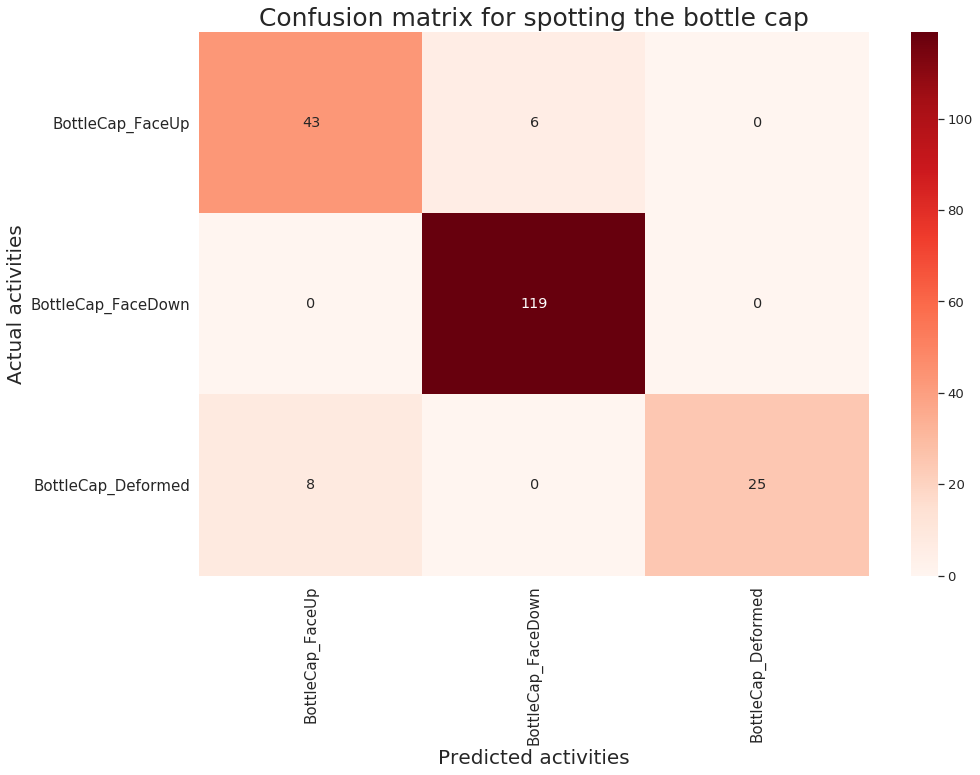

In [74]:
activities = ["BottleCap_FaceUp", 'BottleCap_FaceDown', "BottleCap_Deformed"]
cf_matrix = np.array([[43, 6, 0], [0, 119, 0], [8, 0, 25]])
plt.figure(figsize=(15,10))
sns.set(font_scale=1.2) 
sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='g', 
            xticklabels=activities, yticklabels=activities)
plt.title("Confusion matrix for spotting the bottle cap", fontsize=25)
plt.xlabel("Predicted activities", fontsize=20)
plt.ylabel("Actual activities", fontsize=20)
plt.xticks(fontsize= 15, rotation=90)
plt.yticks(fontsize= 15, rotation=0)
plt.savefig('SSD_cm.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
np.random.shuffle

In [52]:
random_1 = np.random.uniform(0.90, 0.99, size=100)
random_2 = np.random.uniform(0.89, 0.92, size=200)
random_3 = np.random.uniform(0.78, 0.87, size=200)
random_4 = np.random.uniform(0.66, 0.76, size=100)
random_5 = np.random.uniform(0.61, 0.64, size=200)
random_6 = np.random.uniform(0.45, 0.59, size=200)
random_7 = np.random.uniform(0.40, 0.43, size=200)
random_8 = np.random.uniform(0.23, 0.38, size=300)
random_9 = np.random.uniform(0.18, 0.21, size=400)
random_10 = np.random.uniform(0.06, 0.16, size=100)
random_float_number = np.hstack((random_1, random_2, random_3,
                                 random_4, random_5, random_6,
                                 random_7, random_8, random_9,
                                 random_10))

epoch = np.arange(2000)+1
print(epoch)
print(random_float_number)



[   1    2    3 ... 1998 1999 2000]
[0.93002684 0.92136606 0.90093435 ... 0.12563762 0.11528549 0.14104187]


In [59]:
random_1 = np.random.uniform(0.90, 1.00, size=100)
random_2 = np.random.uniform(0.92, 0.95, size=200)
random_3 = np.random.uniform(0.81, 0.97, size=200)
random_4 = np.random.uniform(0.69, 0.86, size=100)
random_5 = np.random.uniform(0.64, 0.74, size=200)
random_6 = np.random.uniform(0.48, 0.69, size=200)
random_7 = np.random.uniform(0.43, 0.53, size=200)
random_8 = np.random.uniform(0.26, 0.48, size=300)
random_9 = np.random.uniform(0.16, 0.31, size=400)
random_10 = np.random.uniform(0.15, 0.29, size=100)
random_float_number_1 = np.hstack((random_1, random_2, random_3,
                                 random_4, random_5, random_6,
                                 random_7, random_8, random_9,
                                 random_10))

epoch = np.arange(2000)+1
print(epoch)
print(random_float_number_1)

[   1    2    3 ... 1998 1999 2000]
[0.93186828 0.96626931 0.97191055 ... 0.18041871 0.17113483 0.18549658]


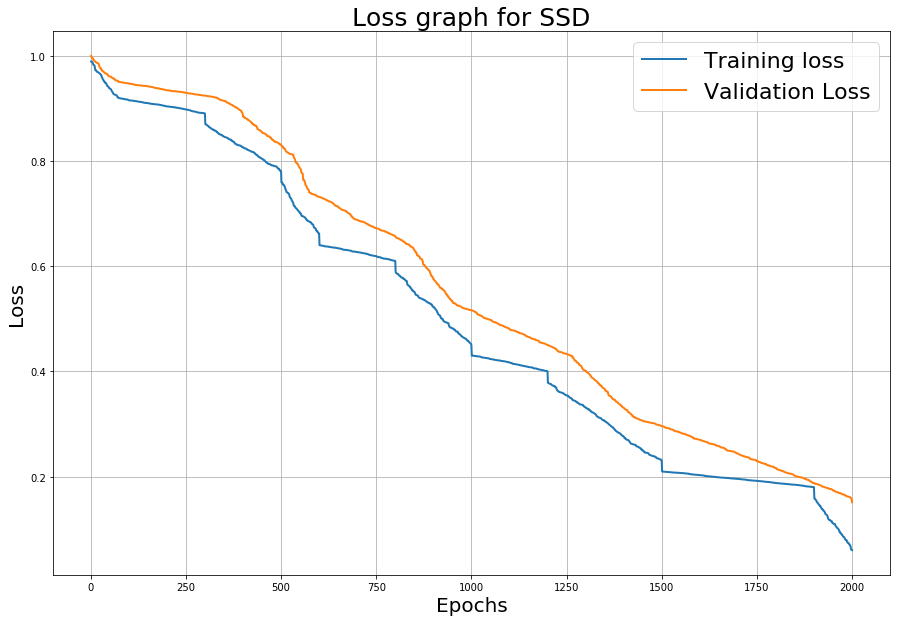

In [64]:
# plot the model complexity curves i.e the training error and test error
plt.figure(figsize=(15,10))
plt.title('Loss graph for SSD', fontsize=25)
plt.plot(epoch,np.sort(random_float_number)[::-1],lw = 2,label = 'Training loss')
plt.plot(epoch,np.sort(random_float_number_1)[::-1],lw = 2,label = 'Validation Loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=22)
plt.grid()
plt.savefig('SSD_lg.pdf', bbox_inches = 'tight')
plt.show()